In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import pymysql
import math
import random
import re
%matplotlib inline
#from preamble import *
import graphviz
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import mglearn
from sklearn.externals import joblib

Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Neural Networks (Deep Learning)
#### The Neural Network Model

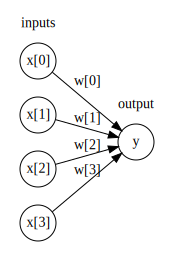

In [2]:
# common logistic regression
display(mglearn.plots.plot_logistic_regression_graph())

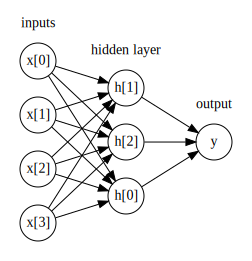

In [3]:
# one layer neural network
display(mglearn.plots.plot_single_hidden_layer_graph())

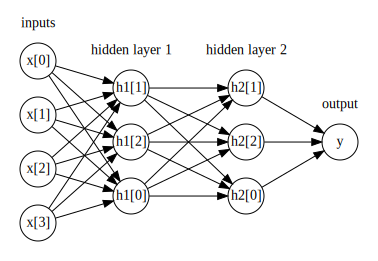

In [4]:
# two layer neural network
mglearn.plots.plot_two_hidden_layer_graph()

#### Activation/squashing functions
* Nonlinear functions that process inputs at each level
* Can take many forms
    * Linear: $f(x) = x$
    * Logistic/(logistic): $f(x) = \frac{ e^x }{ 1 + e^x }$
    * Hyperbolic tangent/(tanh): $f(x) = \frac{ e^x - e^{-x} }{ e^x + e^{-x} }$
    * Rectifier/(RELU): $f(x) = max(x, 0)$
* Hidden units are squashed linear functions of all inputs (one layer neural network)
    * $h0 = f(w_{0,h0} + w_{1,h0}x_{1} + w_{2,h0}x_{2} + w_{3,h0}x_{3})$
    * $h1 = f(w_{0,h1} + w_{1,h1}x_{1} + w_{2,h1}x_{2} + w_{3,h1}x_{3})$
    * $h2 = f(w_{0,h2} + w_{1,h2}x_{1} + w_{2,h2}x_{2} + w_{3,h2}x_{3})$
    * $Out = f(w_{0,O} + w_{1,O}h_{0} + w_{2,O}h_{1} + w_{3,O}h_{2})$
* Economists using NN’s liked logistic functions, many others used tanh()
* Rectifier/RELU has become dominant function for deep NN’s

### Data Preprocessing
#### Load the data

In [5]:
owner = pd.read_csv('data/Owner.csv')
bank_accts = pd.read_csv('data/BankAccount.csv')
company = pd.read_csv('data/Company.csv')
employees = pd.read_csv('data/Employee.csv')
transactions = pd.read_csv('data/ML(New).csv')

print("owner columns:", owner.columns)
print("bank_accts columns:", bank_accts.columns)
print("company columns:", company.columns)
print("employees columns:", employees.columns)
print("transactions columns:", transactions.columns)

owner columns: Index(['entity_type', 'company_id'], dtype='object')
bank_accts columns: Index(['id', 'name', 'subtype', 'type', 'company_id', 'user_id'], dtype='object')
company columns: Index(['id', 'company_type', 'industry', 'user_id'], dtype='object')
employees columns: Index(['company_id', 'total'], dtype='object')
transactions columns: Index(['id', 'account_id', 'balances', 'mask', 'name', 'official_name',
       'subtype', 'type', 'account_owner', 'amount', 'category', 'category_id',
       'ml_category', 'client_category', 'cpa_category', 'ml_accuracy', 'date',
       'location', 'payment_meta', 'pending', 'pending_transaction_id',
       'transaction_id', 'transaction_type', 'bank_accts_id', 'created_at',
       'updated_at', 'user_id', 'description', 'class_method', 'is_confirm',
       'is_confirm_client', 'note'],
      dtype='object')


In [42]:
#merge company table with transactions table
comp_trans = pd.merge(company, transactions, how='inner', on=['user_id'])
#merge bank account table with transactions and company table
comp_trans_bank = pd.merge(comp_trans, bank_accts, how = 'inner', on = 'user_id')
#merge owner account table with bank account,transactions and company table
df = pd.merge(comp_trans_bank, owner, how = 'inner', on = 'company_id')
# glimpse of the merged table
#  df.columns
df.head()

,id_x,company_type,industry,user_id,id_y,account_id,balances,mask,name_x,official_name,...,class_method,is_confirm,is_confirm_client,note,id,name_y,subtype_y,type_y,company_id,entity_type
0,92,S Corporation,Real Estate,306,4378,m5gR83OLmMHJJ45wVoQnsnBZ4XAPvKHMkVQN4,2709.21,2740,TD BUSINESS PREMIER CHECKING,TD BUSINESS PREMIER CHECKING,...,Bank,1,0,NaN,27,TD BUSINESS PREMIER CHECKING,checking,depository,92,NaN
1,92,S Corporation,Real Estate,306,4379,m5gR83OLmMHJJ45wVoQnsnBZ4XAPvKHMkVQN4,2709.21,2740,TD BUSINESS PREMIER CHECKING,TD BUSINESS PREMIER CHECKING,...,Bank,1,0,NaN,27,TD BUSINESS PREMIER CHECKING,checking,depository,92,NaN
2,92,S Corporation,Real Estate,306,4385,m5gR83OLmMHJJ45wVoQnsnBZ4XAPvKHMkVQN4,2709.21,2740,TD BUSINESS PREMIER CHECKING,TD BUSINESS PREMIER CHECKING,...,Bank,1,0,NaN,27,TD BUSINESS PREMIER CHECKING,checking,depository,92,NaN
3,92,S Corporation,Real Estate,306,4387,m5gR83OLmMHJJ45wVoQnsnBZ4XAPvKHMkVQN4,2709.21,2740,TD BUSINESS PREMIER CHECKING,TD BUSINESS PREMIER CHECKING,...,Bank,1,0,NaN,27,TD BUSINESS PREMIER CHECKING,checking,depository,92,NaN
4,92,S Corporation,Real Estate,306,4388,m5gR83OLmMHJJ45wVoQnsnBZ4XAPvKHMkVQN4,2709.21,2740,TD BUSINESS PREMIER CHECKING,TD BUSINESS PREMIER CHECKING,...,ML,1,0,NaN,27,TD BUSINESS PREMIER CHECKING,checking,depository,92,NaN


In [43]:
column_names = df.columns.values.tolist()
print(column_names)

['id_x', 'company_type', 'industry', 'user_id', 'id_y', 'account_id', 'balances', 'mask', 'name_x', 'official_name', 'subtype_x', 'type_x', 'account_owner', 'amount', 'category', 'category_id', 'ml_category', 'client_category', 'cpa_category', 'ml_accuracy', 'date', 'location', 'payment_meta', 'pending', 'pending_transaction_id', 'transaction_id', 'transaction_type', 'bank_accts_id', 'created_at', 'updated_at', 'description', 'class_method', 'is_confirm', 'is_confirm_client', 'note', 'id', 'name_y', 'subtype_y', 'type_y', 'company_id', 'entity_type']


#### Data Preprocesing and selection

In [44]:
# 预处理
df = df[['company_type', 'industry', 'class_method','subtype_x', 'entity_type', 'description','is_confirm',
         'is_confirm_client','category']]
df = df.dropna(subset= ['description'])

df['counter'] = range(len(df))

df.head()

,company_type,industry,class_method,subtype_x,entity_type,description,is_confirm,is_confirm_client,category,counter
0,S Corporation,Real Estate,Bank,checking,NaN,VISA DDA PUR 416407 CREATIVE 12460010 LONG ISL...,1,0,Office Expense,0
1,S Corporation,Real Estate,Bank,checking,NaN,VISA DDA PUR 448347 UPWORK 268782023REF 165 08...,1,0,Contractor,1
2,S Corporation,Real Estate,Bank,checking,NaN,VISA DDA PUR 416407 CREATIVE 12460010 LONG ISL...,1,0,Office Expense,2
3,S Corporation,Real Estate,Bank,checking,NaN,VISA DDA PUR 490641 PAYONEER COM 158686330 800...,1,0,Contractor,3
4,S Corporation,Real Estate,ML,checking,NaN,Venmo,1,0,Contractor,4


In [45]:
#remove class method equal to "ML" that is_confirm = 0
df_temp = df[(df['class_method'] == 'ML') & (df['is_confirm'] == 1.0)]
#remove class method equal to "ML" that is_confirm_client = 0
df_confirm_0 = df[(df['class_method'] == 'ML') & (df['is_confirm_client'] == 1.0)]
#merge the two type of confirm data
df_confirm_1 = df_temp.merge(df_confirm_0, how = "outer" )
#drop duplicates
df_confirm = df_confirm_1.drop_duplicates()

In [46]:
#df_confirm  # 112 rows
df_confirm.head()  # 112 rows

,company_type,industry,class_method,subtype_x,entity_type,description,is_confirm,is_confirm_client,category,counter
0,S Corporation,Real Estate,ML,checking,NaN,Venmo,1,0,Contractor,4
1,S Corporation,Real Estate,ML,checking,NaN,Venmo,1,0,Contractor,7
2,S Corporation,Real Estate,ML,checking,NaN,Venmo,1,0,Contractor,8
3,S Corporation,Real Estate,ML,checking,NaN,Venmo,1,0,Contractor,9
4,S Corporation,Real Estate,ML,checking,NaN,Venmo,1,0,Contractor,10


In [47]:
df_confirm['counter'].unique()

array([  4,   7,   8,   9,  10,  11,  16,  17,  19,  21,  23,  25,  28,
        30,  31,  32,  36,  37,  43,  44,  45,  46,  48,  49,  51,  52,
        54,  55,  56,  59,  62,  65,  67,  68,  71,  74,  77,  78,  82,
        83,  84,  89,  90,  91,  98, 102, 103, 104, 106, 108, 109, 112,
       117, 118, 119, 121, 124, 127, 128, 129, 132, 133, 135, 141, 144,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162,
       164, 165, 167, 169, 170, 171, 172, 173, 175, 176, 177, 178, 180,
       181, 182, 183, 184, 185, 186, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 198, 199, 201, 202, 204, 205, 206, 208, 211, 212, 213,
       214, 215, 216, 217, 218, 220, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 236, 237, 238, 239, 240, 242, 243, 244, 245,
       246, 248, 249, 250, 251, 252, 253, 254, 255, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 267, 270, 271, 272, 273, 274, 275,
       277, 278, 279, 281, 282, 283, 284, 285, 286, 288, 290, 29

In [48]:
#df_confirm['company_type'].unique()
for i in df_confirm.columns.values.tolist():
    print('Unique Value - ', i, ' : ', df_confirm[str(i)].unique())

Unique Value -  company_type  :  ['S Corporation']
Unique Value -  industry  :  ['Real Estate']
Unique Value -  class_method  :  ['ML']
Unique Value -  subtype_x  :  ['checking']
Unique Value -  entity_type  :  [nan]
Unique Value -  description  :  ['Venmo' 'VISA DDA PUR 449215 PAYPAL BRIAN *'
 'VISA DDA PUR 449215 PAYPAL LUCKYORANGE *' 'DEBIT'
 'VISA DDA PUR 469216 INTUIT QUICKBOOKS *'
 'VISA DDA PUR 473309 BLS SEMRUSH *'
 'VISA DDA PUR 424818 PAYPAL MAGDINAALLA VISA DIRECT *'
 'VISA DDA REF 448347 UPWORK 255881362JOBPOST 165 08534100 *'
 'DEBIT CARD PURCHASE, AUT 090219 VISA DDA PUR'
 'DEBIT CARD PURCHASE, AUT 082819 VISA DDA PUR'
 'DEBIT CARD PURCHASE, AUT 082619 VISA DDA PUR'
 'DEBIT CARD PURCHASE, AUT 082319 VISA DDA PUR'
 'DEBIT CARD PURCHASE, AUT 082119 VISA DDA PUR'
 'DEBIT CARD PURCHASE, AUT 082219 VISA DDA PUR'
 'DEBIT CARD PURCHASE, AUT 082019 VISA DDA PUR'
 'DEBIT CARD PURCHASE, AUT 081819 VISA DDA PUR'
 'DEBIT CARD PURCHASE, AUT 081919 VISA DDA PUR'
 'DEBIT CARD PURCHASE, 

In [50]:
print('Number of data each category:')
total = 0
for x in df_confirm['category'].unique() :
    print(x, len(df_confirm[df_confirm['category'] == x]))
    total = total + len(df_confirm[df_confirm['category'] == x])
print('total:' , total)

Number of data each category:
Contractor 37
Office Expense 153
Commission Expense 81
Marketing Expense 2
Sales Revenue 6
total: 279


### _Function CategorySizePieChart_
- Parameters: dataframe that will be plot
- Returns   : None
- Does      : Plot the dataframe base on its category szie

In [51]:
def CategorySizePieChart(df):
    labels = df['category'].unique()
    sizes = [len(df[df['category'] == x]) for x in labels]

    fig1, ax= plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))
    

    wedges, texts, autotexts = ax.pie(sizes, autopct='%1.1f%%',
                                  textprops=dict(color="w"),  startangle=90)

    ax.legend(wedges, labels,
          title="Categories",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=8, weight="bold")

    ax.set_title("data in each category: a pie")
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

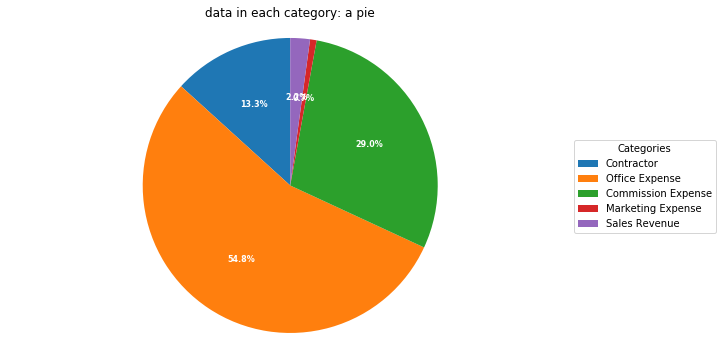

In [52]:
CategorySizePieChart(df_confirm)

In [53]:
print('unique description for each category')
for x in df_confirm['category'].unique() :
    print(x, len(df_confirm[df_confirm['category'] == x]['description'].unique()))
#max_num = np.amax([len(df[df['category']== x]['description'].unique()) for x in category_set])

unique description for each category
Contractor 4
Office Expense 105
Commission Expense 1
Marketing Expense 1
Sales Revenue 1


### _Function BalanceEnlargeCategorySize_
- Parameters: dataframe that need to be balance
- Returns   : dataframe that every category size is the same
- Does      : enlarge category to the same size

In [54]:
def BalanceEnlargeCategorySize(df):
    category_set = df['category'].unique()
    # create an empty DataFrame
    columns_name = df.columns.values.tolist()
    df_all = pd.DataFrame(columns=columns_name)

    for x in category_set:
        df_x = df[df['category'] == x]
        counter_list = df_x['counter'].values.tolist()
        for i in range(10):
            counter_list.extend(counter_list)    
        enlarge_id_list = random.sample(counter_list, 1200)
        oversample_id = pd.DataFrame({"counter": enlarge_id_list})
        oversample_ML = oversample_id.merge(df_x, on = 'counter',how = 'inner')
        df_all = pd.concat([df_all, oversample_ML])
        
    return df_all

In [55]:
df_balance = BalanceEnlargeCategorySize(df_confirm)
#category_set
df_balance.head()  # 6000 rows

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


,category,class_method,company_type,counter,description,entity_type,industry,is_confirm,is_confirm_client,subtype_x
0,Contractor,ML,S Corporation,4,Venmo,NaN,Real Estate,1,0,checking
1,Contractor,ML,S Corporation,4,Venmo,NaN,Real Estate,1,0,checking
2,Contractor,ML,S Corporation,4,Venmo,NaN,Real Estate,1,0,checking
3,Contractor,ML,S Corporation,4,Venmo,NaN,Real Estate,1,0,checking
4,Contractor,ML,S Corporation,4,Venmo,NaN,Real Estate,1,0,checking


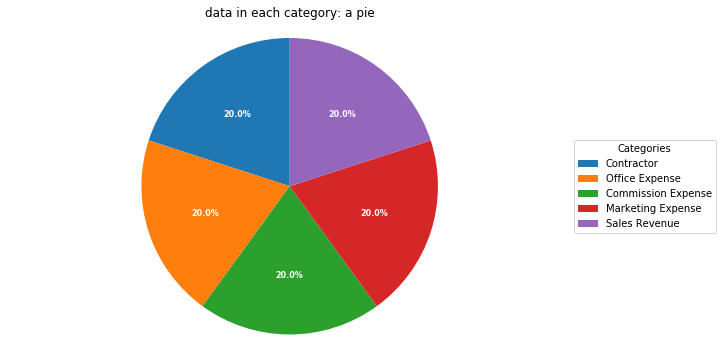

In [56]:
CategorySizePieChart(df_balance)

<h2 id="modeling">Transform description (X) into vectors</h2>
<hr>

### _Function cleanSentences_
- Parameters: strings that not only contains alphanumeric characters
- Returns   : strings that only contains alphanumeric characters
- Does      : Removes punctuation, parentheses, question marks, etc. 

In [57]:
def cleanSentences(string):
    strip_special_chars = re.compile("[^A-Za-z0-9 ]+")
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

### _Function clarifyVectorShape_ 
- Parameters: dataframe that has description
- Returns   : vector's shape
- Does      : Calculate the longest length of description

In [58]:
def clarifyVectorShape(df):
    descriptions = pd.DataFrame(df['description'])  # x: description
    num_Descriptions = len(descriptions)

    num_Words = []
    for i,j in enumerate(descriptions['description']):
        counter = len(j.split())
        num_Words.append(counter)  
    max_SeqLength = math.ceil(max(num_Words))
        
    return num_Descriptions, max_SeqLength

In [59]:
numDescriptions = clarifyVectorShape(df_balance)[0]
maxSeqLength = clarifyVectorShape(df_balance)[1]
print("numDescriptions: ", numDescriptions)
print("maxSeqLength: ", maxSeqLength)

numDescriptions:  6000
maxSeqLength:  9


### _Function TextToVector_
- Parameters: dataframe
- Returns   : vectors
- Does      : Transform strings to vectors

In [60]:
def TextToVector(df):
    wordsList = np.load('data/wordsList.npy')
    wordsList = wordsList.tolist()  #Originally loaded as numpy array
    wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
    wordVectors = np.load('data/wordVectors.npy')
    
    descriptions = pd.DataFrame(df['description'])  # x: description
    
    features = np.zeros((numDescriptions, maxSeqLength), dtype='int32')
    fileCounter = 0

    for i,j in enumerate(descriptions['description']):  
        indexCounter = 0  
        cleanedLine = cleanSentences(j)  
        split = cleanedLine.split()  
        for word in split:  
            try:  
                features[fileCounter][indexCounter] = wordsList.index(word)  
            except ValueError:  
                features[fileCounter][indexCounter] = 399999  # Vector for unkown words
            indexCounter = indexCounter + 1  
            if indexCounter >= maxSeqLength:  
                break  
        fileCounter = fileCounter + 1 

    return fileCounter, features

In [61]:
fileCounter = TextToVector(df_balance)[0]
features = TextToVector(df_balance)[1]

In [62]:
print(fileCounter)
print(features)
print(features.shape)
print(type(features))

6000
[[399999      0      0 ...      0      0      0]
 [399999      0      0 ...      0      0      0]
 [399999      0      0 ...      0      0      0]
 ...
 [399999   1164   1292 ...      0      0      0]
 [399999   1164   1292 ...      0      0      0]
 [399999   1164   1292 ...      0      0      0]]
(6000, 9)
<class 'numpy.ndarray'>


In [63]:
#features_2.head(200)
features_scaled = preprocessing.scale(features)
features_scaled

array([[ 1.29425407, -0.57064303, -0.61225307, ..., -0.49641866,
        -0.28541615,  0.        ],
       [ 1.29425407, -0.57064303, -0.61225307, ..., -0.49641866,
        -0.28541615,  0.        ],
       [ 1.29425407, -0.57064303, -0.61225307, ..., -0.49641866,
        -0.28541615,  0.        ],
       ...,
       [ 1.29425407, -0.53671654, -0.52237628, ..., -0.49641866,
        -0.28541615,  0.        ],
       [ 1.29425407, -0.53671654, -0.52237628, ..., -0.49641866,
        -0.28541615,  0.        ],
       [ 1.29425407, -0.53671654, -0.52237628, ..., -0.49641866,
        -0.28541615,  0.        ]])

<h2 id="modeling">Transform category (Y) into vectors</h2>
<hr>

In [64]:
def toLabel(df):
    categories = pd.DataFrame(df['category'])  # y: category
    numCategories = len(categories)

    for x in ['category']:
        le = LabelEncoder()  # 用来对分类型特征值进行编码，即对不连续的数值或文本进行编码
        le.fit(list(categories[x].values))
        categories[x] = le.transform(list(categories[x])) 
        # Contractor: 1; Office Expense = 3; Commission Expense = 0; Marketing Expense = 2; Sales Revenue = 4

    maxnum_cat = max(categories['category'])  # maxnum_cat = 4
    
    target_1d = np.array(categories['category'].tolist())

    target_nd = to_categorical(categories['category'], maxnum_cat+1)
    # Contractor: [0., 1., 0., 0., 0.]
    # Office Expense = [0., 0., 0., 1., 0.] 
    # Commission Expense = [1., 0., 0., 0., 0.] 
    # Marketing Expense = [0., 0., 1., 0., 0.] 
    # Sales Revenue = [0., 0., 0., 0., 1.]
    
    return target_1d, target_nd

In [65]:
target_1d = toLabel(df_balance)[0]
target_nd = toLabel(df_balance)[1]

In [66]:
print(target_1d.shape)
print(target_1d)
print(type(target_1d))

print(target_nd.shape)
print(target_nd)
print(type(target_nd))

(6000,)
[1 1 1 ... 4 4 4]
<class 'numpy.ndarray'>
(6000, 5)
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
<class 'numpy.ndarray'>


<h2 id="modeling">Splitting into training and test set</h2>
<hr>

In [67]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_1d, test_size=0.50,random_state=1)

In [68]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3000, 9)
(3000,)
(3000, 9)
(3000,)


<h2 id="#modeling">Modeling</h2>
<hr>

### one-layer MLP

In [69]:
mlp_1 = MLPClassifier(hidden_layer_sizes=(50))  # hidden_layer_sizes=[50]就是在中间层有50个units，而不是有50个中间层
mlp_1.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(
    mlp_1.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp_1.score(X_test, y_test)))

Accuracy on training set: 0.992
Accuracy on test set: 0.988


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [70]:
mlp_1.predict([[399999, 0, 0, 0, 0, 0, 0, 0, 0]])

array([4])

### two-layer MLP

In [71]:
mlp_2 = MLPClassifier(hidden_layer_sizes=(50,50))  # hidden_layer_sizes=[50]就是在中间层有50个units，而不是有50个中间层
# ？！！有个一般的标准，不要超过一个值（根据输入输出节点去看）
mlp_2.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(
    mlp_2.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp_2.score(X_test, y_test)))

Accuracy on training set: 0.999
Accuracy on test set: 0.999


In [72]:
mlp_2.predict([[399999, 0, 0, 0, 0, 0, 0, 0, 0]])

array([1])

### Prediction

### _Function predict_category_
- Parameters: a matrix with shape as (n,9)
- Returns   : n specific categories
- Does      : Transform vectors to categories

In [91]:
# input一个(n,9)的矩阵，然后output一个n个具体的category
def predict_category(input_matrix):
    target_predict_num = mlp_2.predict(input_matrix)
    target_predict_text = []
    
    for i in target_predict_num:
        if i == 0:
            target_predict_text.append('Commission Expense')
        elif i == 1:
            target_predict_text.append('Contractor')
        elif i == 2:
            target_predict_text.append('Marketing Expense')
        elif i == 3:
            target_predict_text.append('Office Expense')
        elif i == 4:
            target_predict_text.append('Sales Revenue')
    
    target_predict = np.array(target_predict_text)

    return target_predict   

In [92]:
target_predict_1 = predict_category(X_train)
target_predict_2 = predict_category([[399999, 0, 0, 0, 0, 0, 0, 0, 0]])

In [93]:
target_predict_1

array(['Sales Revenue', 'Marketing Expense', 'Commission Expense', ...,
       'Marketing Expense', 'Contractor', 'Sales Revenue'], dtype='<U18')

In [94]:
target_predict_2

array(['Contractor'], dtype='<U10')

<h2 id="#model evaluation">Model Evaluation</h2>
<hr>

In [73]:
#!pip install git+http://github.com/scikit-learn/scikit-learn.git
#!conda update scikit-learn --yes
#!conda install scikit-learn==0.21.dev0
#!pip uninstall scikit-learn --y
#!pip install scikit-learn==0.21.1
#!upgrade pip scikit-learn
#!pip install git+http://github.com/scikit-learn/scikit-learn.git

In [74]:
predictions = mlp_2.predict(X_test)
predictions

array([3, 3, 0, ..., 2, 3, 4])

In [75]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

### _Function plot_confusion_matrix_
- Parameters: cm, classes
- Returns   : plot
- Does      : Plot the confustion matrix

In [76]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[587   0   0   0   0]
 [  0 608   0   0   0]
 [  0   0 625   0   0]
 [  0   0   3 599   0]
 [  0   0   0   0 578]]


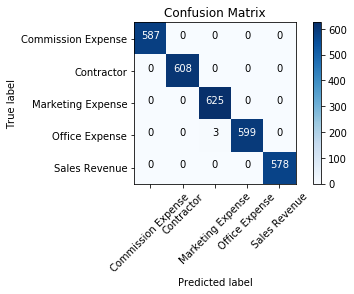

In [77]:
cm = confusion_matrix(y_true=y_test, y_pred=predictions)

cm_plot_labels = ['Commission Expense','Contractor', 'Marketing Expense', 'Office Expense', 'Sales Revenue']
# Contractor: 1; Office Expense = 3; Commission Expense = 0; Marketing Expense = 2; Sales Revenue = 4

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

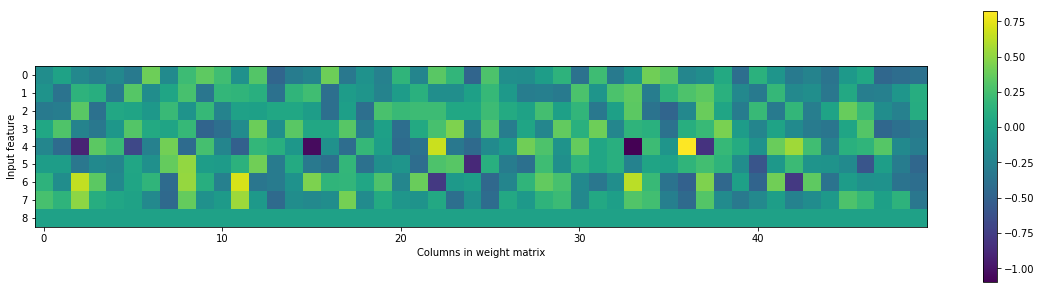

In [95]:
plt.figure(figsize=(20, 5))
plt.imshow(mlp_2.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(range(9))
plt.xlabel("Columns in weight matrix")
plt.ylabel("Input feature")
plt.colorbar()

<h2 id="#model Persistence">Model Persistence</h2>
<hr>
use joblib’s dump & load to persist the Neural Network model.

In [80]:
joblib.dump(mlp_2,'models/text_NeuralNetwork.pkl')

['models/text_NeuralNetwork.pkl']

load back the pickled model

In [81]:
test_clf=joblib.load('models/text_NeuralNetwork.pkl')
pred = test_clf.predict(X_test)
print("Test set Accuracy: ", accuracy_score(y_test, pred))

Test set Accuracy:  0.999
